In [1]:
# Install required packages
import subprocess
import sys

def install_package(package):
    """Install a package using pip"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install matplotlib if not already installed
try:
    import matplotlib
    print("matplotlib is already installed")
except ImportError:
    print("Installing matplotlib...")
    install_package("matplotlib")
    print("matplotlib installed successfully!")

matplotlib is already installed


# Sampling Strategies Demo

This notebook demonstrates the sampling functionality with error bounds calculations.

In [16]:
"""Demo script showing how to use the sampling module."""

from sampling import SimpleRandomSampler, StratifiedSampler, SamplingConfig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Simple Random Sampling Demo

In [17]:
def demo_simple_random():
    """Demonstrate simple random sampling."""
    print("\n=== Simple Random Sampling Demo ===")
    
    # Create example data
    np.random.seed(42)
    data = pd.DataFrame({
        'value': np.random.normal(100, 15, 1000000),
        'category': np.random.choice(['A', 'B', 'C'], 1000000)
    })
    
    # Create sampler with bootstrap error estimation
    config = SamplingConfig(
        confidence_level=0.95,
        error_method='bootstrap',
        n_bootstrap=1000
    )
    sampler = SimpleRandomSampler(config)
    
    # Take sample and calculate error bounds
    sample = sampler.sample(data, size=10000)
    bounds = sampler.estimate_error_bounds(sample, 'value')
    
    # Print results
    print(f"\nTrue population mean: {data['value'].mean():.2f}")
    print(f"Sample mean: {bounds.estimate:.2f}")
    print(f"95% CI: [{bounds.lower_bound:.2f}, {bounds.upper_bound:.2f}]")
    print(f"Margin of error: ±{bounds.margin_of_error:.2f}")
    print(f"Relative error: {bounds.relative_error:.2%}")
    
    return data, sample, bounds

# Run the demo
data, sample, bounds = demo_simple_random()


=== Simple Random Sampling Demo ===

True population mean: 99.98
Sample mean: 99.99
95% CI: [99.71, 100.27]
Margin of error: ±0.28
Relative error: 0.28%


## Stratified Sampling Demo

In [18]:
def demo_stratified():
    """Demonstrate stratified sampling."""
    print("\n=== Stratified Sampling Demo ===")
    
    # Create example data with different distributions per category
    np.random.seed(42)
    data = pd.DataFrame({
        'category': np.repeat(['A', 'B', 'C'], [500000, 300000, 200000]),
        'value': np.concatenate([
            np.random.normal(100, 10, 500000),  # Category A
            np.random.normal(150, 20, 300000),  # Category B
            np.random.normal(80, 5, 200000)     # Category C
        ])
    })
    
    # Create stratified sampler
    config = SamplingConfig(
        confidence_level=0.95,
        error_method='student_t'
    )
    sampler = StratifiedSampler(config)
    
    # Take stratified sample
    sample = sampler.sample(
        data,
        strata_column='category',
        size=10000,
        allocation='optimal'
    )
    bounds = sampler.estimate_error_bounds(
        sample, 'value', strata_column='category'
    )
    
    # Print results per stratum
    print("\nPopulation statistics per category:")
    print(data.groupby('category')['value'].agg(['count', 'mean', 'std']))
    
    print("\nSample statistics per category:")
    print(sample.groupby('category')['value'].agg(['count', 'mean', 'std']))
    
    print("\nOverall estimates:")
    print(f"Sample mean: {bounds.estimate:.2f}")
    print(f"95% CI: [{bounds.lower_bound:.2f}, {bounds.upper_bound:.2f}]")
    print(f"Margin of error: ±{bounds.margin_of_error:.2f}")
    print(f"Relative error: {bounds.relative_error:.2%}")
    
    return data, sample, bounds

# Run the stratified demo
strat_data, strat_sample, strat_bounds = demo_stratified()


=== Stratified Sampling Demo ===

Population statistics per category:
           count        mean        std
category                               
A         500000   99.988338  10.004704
B         300000  150.017004  20.008380
C         200000   79.968207   4.995632

Sample statistics per category:
          count        mean        std
category                              
A          4168  100.037638  10.016693
B          5000  149.933874  20.019492
C           832   80.025262   5.116459

Overall estimates:
Sample mean: 123.32
95% CI: [123.01, 123.63]
Margin of error: ±0.31
Relative error: 0.25%
           count        mean        std
category                               
A         500000   99.988338  10.004704
B         300000  150.017004  20.008380
C         200000   79.968207   4.995632

Sample statistics per category:
          count        mean        std
category                              
A          4168  100.037638  10.016693
B          5000  149.933874  20.019492
C 

## Visualization of Results

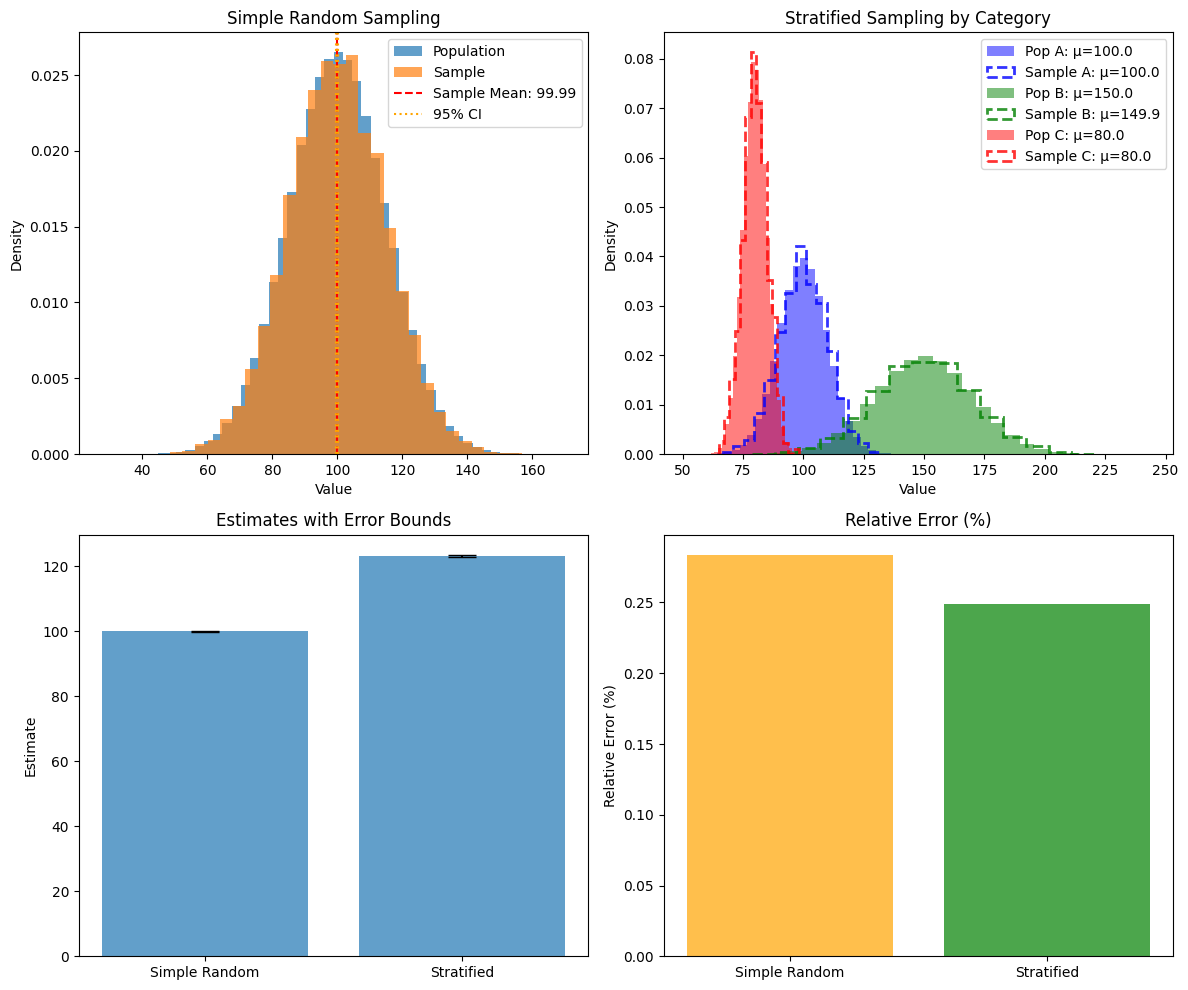


=== Summary ===
Simple Random Sampling: 99.99 ± 0.28 (0.28% error)
Stratified Sampling: 123.32 ± 0.31 (0.25% error)


In [20]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Simple random sampling histogram
axes[0, 0].hist(data['value'], bins=50, alpha=0.7, label='Population', density=True)
axes[0, 0].hist(sample['value'], bins=30, alpha=0.7, label='Sample', density=True)
axes[0, 0].axvline(bounds.estimate, color='red', linestyle='--', label=f'Sample Mean: {bounds.estimate:.2f}')
axes[0, 0].axvline(bounds.lower_bound, color='orange', linestyle=':', label=f'95% CI')
axes[0, 0].axvline(bounds.upper_bound, color='orange', linestyle=':')
axes[0, 0].set_title('Simple Random Sampling')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Density')

# Stratified sampling by category
categories = ['A', 'B', 'C']
colors = ['blue', 'green', 'red']
for i, cat in enumerate(categories):
    pop_data = strat_data[strat_data['category'] == cat]['value']
    sample_data = strat_sample[strat_sample['category'] == cat]['value']
    
    axes[0, 1].hist(pop_data, bins=30, alpha=0.5, color=colors[i], 
                   label=f'Pop {cat}: μ={pop_data.mean():.1f}', density=True)
    axes[0, 1].hist(sample_data, bins=15, alpha=0.8, color=colors[i], 
                   linestyle='--', histtype='step', linewidth=2,
                   label=f'Sample {cat}: μ={sample_data.mean():.1f}', density=True)

axes[0, 1].set_title('Stratified Sampling by Category')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Density')

# Error bounds comparison
methods = ['Simple Random', 'Stratified']
estimates = [bounds.estimate, strat_bounds.estimate]
margins = [bounds.margin_of_error, strat_bounds.margin_of_error]

axes[1, 0].bar(methods, estimates, yerr=margins, capsize=10, alpha=0.7)
axes[1, 0].set_title('Estimates with Error Bounds')
axes[1, 0].set_ylabel('Estimate')

# Relative error comparison
rel_errors = [bounds.relative_error * 100, strat_bounds.relative_error * 100]
axes[1, 1].bar(methods, rel_errors, alpha=0.7, color=['orange', 'green'])
axes[1, 1].set_title('Relative Error (%)')
axes[1, 1].set_ylabel('Relative Error (%)')

plt.tight_layout()
plt.show()

print("\n=== Summary ===")
print(f"Simple Random Sampling: {bounds.estimate:.2f} ± {bounds.margin_of_error:.2f} ({bounds.relative_error:.2%} error)")
print(f"Stratified Sampling: {strat_bounds.estimate:.2f} ± {strat_bounds.margin_of_error:.2f} ({strat_bounds.relative_error:.2%} error)")